<h1>
<center>Dynamic Graph Convolution Neural Networks </center>
</h1>

<font size="3">
This notebook provides an end-to-end solution for training graph neural networks (GNNs) and evaluating their performance on a cryptocurrency price prediction problem. The notebook supports the use of different types of GNNs by changing environment variables. The following Pytorch networks are available for experimentation:
<br>
A3TGCN2, DCRNN, TGCN, TGCN2, GConvGRU, GConvLSTM, GCLSTM.
<br>
<br>
The notebook follows the following steps:
<li>The notebook loads the graph structured information created in a previous notebook.</li>
<li>A custom data loader is created to convert the data into the appropriate dynamic format for input into the dynamic GNN.</li>
<li>Flexible functions are created to support the use of different GNNs by changing only environment variables.</li>
<li>An evaluation function is created to measure and store four different evaluation metrics.</li>
<li>The model is trained and evaluated using the validation set to find the best hyperparameters.</li>
<li>The model is trained using the entire training set, and its performance is evaluated.</li>
<li>Plots with the evaluation metrics are generated and stored.</li>
<li>The model predictions are stored for use in the next notebook for backtesting.</li>
</font>

## Generals 

<font size="3"> 
Packages import and system configurations. 
</font>

In [1]:
#Data
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from numpy import *
#Graph Counstruction
import torch
from torch_geometric_temporal.signal import StaticGraphTemporalSignal,DynamicGraphTemporalSignal
import torch
import torchmetrics

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN2, DCRNN, TGCN2, TGCN,  GConvGRU, GConvLSTM, GCLSTM
from torch.nn import Linear
from torch.nn import ReLU
import matplotlib.pyplot as plt


<font size="3"> 
Define necessary paths. 
</font>

In [27]:
data_intermediate_path ='io/input/data_intermediate/'
export_path = 'io/output/exports/'
test_path = 'io/input/base_data/test.csv'

train_node_features_path = data_intermediate_path + 'node_features/train/'
train_node_labels_path = data_intermediate_path + 'node_labels/train/'
train_edges_path = data_intermediate_path + 'edges/train/'
train_edge_weights_path = data_intermediate_path + 'edge_weights/train/'

val_node_labels_path = data_intermediate_path + 'node_labels/val/'
val_node_features_path = data_intermediate_path + 'node_features/val/'
val_edges_path = data_intermediate_path + 'edges/val/'
val_edge_weights_path = data_intermediate_path + 'edge_weights/val/'

test_node_labels_path = data_intermediate_path + 'node_labels/test/'
test_node_features_path = data_intermediate_path + 'node_features/test/'
test_edges_path = data_intermediate_path + 'edges/test/'
test_edge_weights_path = data_intermediate_path + 'edge_weights/test/'

predictions_path = export_path + 'predictions/'
metrics_plot_path = export_path + 'metrics_plots/'
results_path = export_path + 'experiments_results/'

## Core Functionality

<font size="3"> 
Load numpy arrays on chunks. 
</font>

In [3]:
def load_object(path):
    num_chunks = len([f for f in os.listdir(path) if f.startswith('chunk_') and f.endswith('.npy')])
    # Load array from chunks
    chunks = []
    for i in range(num_chunks):
        filename = f"{path}chunk_{i}.npy"
        chunk = np.load(filename,allow_pickle=True)
        chunks.append(chunk)
    arr_reconstructed = np.concatenate(chunks, axis=0)
    return arr_reconstructed

<font size="3"> 
Load all graph information and print shapes
</font>

In [4]:
train_node_features = load_object(train_node_features_path)
train_node_labels = load_object(train_node_labels_path)
train_edges = load_object(train_edges_path)
train_edge_weights = load_object(train_edge_weights_path)

val_node_features = load_object(val_node_features_path)
val_node_labels = load_object(val_node_labels_path)
val_edges = load_object(val_edges_path) ##
val_edge_weights = load_object(val_edge_weights_path) ##

test_node_features = load_object(test_node_features_path)
test_node_labels = load_object(test_node_labels_path)
test_edges = load_object(test_edges_path)
test_edge_weights = load_object(test_edge_weights_path)

print('Train Node Features Train',train_node_features.shape)
print('Train Node Labels Train',train_node_labels.shape)
print('Train Edges Shape',train_edges.shape)
print('Train Edges Weights Shapes',train_edge_weights.shape)
print('\n')
print('Validation Node Features Train',val_node_features.shape)
print('Validation Node Labels Train',val_node_labels.shape)
print('Validation Edges Shape',val_edges.shape)
print('Validation Edges Weights Shapes',val_edge_weights.shape)
print('\n')
print('Test Node Features Train',test_node_features.shape)
print('Test Node Labels Train',test_node_labels.shape)
print('Test Edges Shape',test_edges.shape)
print('Test Edges Weights Shapes',test_edge_weights.shape)

Train Node Features Train (5370, 8, 21, 1)
Train Node Labels Train (5370, 8, 1)
Train Edges Shape (5370, 2, 64)
Train Edges Weights Shapes (5370, 64)


Validation Node Features Train (2005, 8, 21, 1)
Validation Node Labels Train (2005, 8, 1)
Validation Edges Shape (2005, 2, 64)
Validation Edges Weights Shapes (2005, 64)


Test Node Features Train (622, 8, 21, 1)
Test Node Labels Train (622, 8, 1)
Test Edges Shape (622, 2, 64)
Test Edges Weights Shapes (622, 64)


## Convert Graph info to data loaders

<font size="3"> 
Zero small edge weights according to a threshold
<br>
This is used to optimize the edges according to our problem
</font>

In [5]:
edge_threshold = 0.2

# train_edge_weights[train_edge_weights == 1] = 0 #We exclude self edges
train_edge_weights[train_edge_weights < edge_threshold] = 0
# train_edge_weights = train_edge_weights * train_edge_weights

# val_edge_weights[val_edge_weights == 1] = 0 #We exclude self edges
val_edge_weights[val_edge_weights < edge_threshold] = 0
# val_edge_weights = val_edge_weights * val_edge_weights

# test_edge_weights[test_edge_weights == 1] = 0 #We exclude self edges
test_edge_weights[test_edge_weights < edge_threshold] = 0
# test_edge_weights = test_edge_weights * test_edge_weights

<font size="3"> 
This is a costum loader that we use to have at the same loader, features, targets edges and edge-weigths
<br>
<br>
The function performs the following steps:
<ol>
<li>Convert the graph features, targets, edges, and edge weights into PyTorch tensors.</li>
<li>Create a TensorDataset object using the PyTorch tensors.</li>
<li>Define a custom data loader class that inherits from DataLoader and overrides the collate_fn method to stack the data into batches.</li>
<li>Create an instance of the custom data loader class and return it.</li>
</ol>
</font>

In [6]:
def dynamic_data_loader(graph,batch_size):
    features = np.array(graph.features)
    targets = np.array(graph.targets)
    edges = np.array(graph.edge_indices)
    edge_attr = np.array(graph.edge_weights)
    features_tensor = torch.from_numpy(features).type(torch.FloatTensor)
    targets_tensor = torch.from_numpy(targets).type(torch.FloatTensor)
    edges_tensor = torch.from_numpy(edges).type(torch.LongTensor)
    edge_attr_tensor = torch.from_numpy(edge_attr).type(torch.FloatTensor)
    dataset_new = torch.utils.data.TensorDataset(features_tensor, edges_tensor, edge_attr_tensor, targets_tensor)
    
    class CustomDataLoader(torch.utils.data.DataLoader):
        def __init__(self, dataset, batch_size, drop_last):
            super().__init__(dataset, batch_size=batch_size, drop_last=drop_last)

        def collate_fn(self, data):
            features, edges, edge_attr, targets = zip(*data)
            batch_features = torch.stack(features)
            batch_edges = torch.stack(edges)
            batch_edge_attr = torch.stack(edge_attr)
            batch_targets = torch.stack(targets)
            return batch_features, batch_edges, batch_edge_attr, batch_targets
    graph_loader = CustomDataLoader(dataset_new, batch_size=batch_size, drop_last=False)
    return graph_loader

<font size="3"> 
We use the above function to apply the custom loader
</font

In [7]:
def graph_data_loader(batch_size,train_edges,train_edge_weights,train_node_features,train_node_labels,
                      test_edges,test_edge_weights,test_node_features,test_node_labels):

    graph_train = DynamicGraphTemporalSignal(edge_indices=train_edges,edge_weights=train_edge_weights,
                                   features=train_node_features,targets=train_node_labels)


    graph_test = DynamicGraphTemporalSignal(edge_indices=test_edges,edge_weights=test_edge_weights,
                                   features=test_node_features,targets=test_node_labels)

    
    train_loader = dynamic_data_loader(graph_train,batch_size)
    test_loader = dynamic_data_loader(graph_test,batch_size)
    return train_loader,test_loader

## GNN Models & Architectures

<font size="3"> 
This function defines a temporal graph neural network with an RNN-based architecture for node regression. It allows for flexible selection of GCN and filtering methods.
<br>
<br>
The function performs the following steps:
<ol>   
<li>Initialize a graph convolutional neural network (GCN) based on the chosen type (e.g. A3TGCN2).</li>
<li>Define three hidden layers with ReLU activation functions.</li>
<li>Define a linear output layer with specified number of periods.</li>
<li>Define forward propagation method that applies the GCN, ReLU, hidden layers, and output layer to input data.</li>
</ol> 
</font>

In [8]:
class TemporalGNN_RNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size, gcn, filter_size):
        super(TemporalGNN_RNN, self).__init__()
        
        if gcn == 'A3TGCN2':
            self.tgnn = A3TGCN2(in_channels=node_features, periods=periods, out_channels=64, batch_size=batch_size, cached=True)
        elif gcn == 'DCRNN':
            self.tgnn = DCRNN(in_channels=node_features, out_channels=64, K=periods)
        elif gcn == 'TGCN2':
            self.tgnn = TGCN2(in_channels=node_features, out_channels=64, batch_size=batch_size, cached=True)
        elif gcn == 'TGCN':
            self.tgnn = TGCN(in_channels=node_features, out_channels=64, cached=True)
        elif gcn == 'GConvGRU':
            self.tgnn = GConvGRU(in_channels=node_features, out_channels=64, K=filter_size)

        self.hidden2 = Linear(64, 32)        
        self.act2 = ReLU()
        
        self.lstm = torch.nn.LSTM(32, 16, 1, batch_first=True, bidirectional=True)
        
        self.hidden3 = Linear(32, 16)
        self.act3 = ReLU()        

        self.linear = torch.nn.Linear(16, periods)       

    def forward(self, x, edge_index, edge_weight):
        h = self.tgnn(x, edge_index, edge_weight)
        h = F.relu(h)

        h0 = torch.zeros(2, h.size(0), 16).requires_grad_()
        c0 = torch.zeros(2, h.size(0), 16).requires_grad_()
        
        h = self.hidden2(h)
        h = self.act2(h)
        
        out, (hn, cn) = self.lstm(h, (h0.detach(), c0.detach()))
        
        h = self.hidden3(out)
        h = self.act3(h)
        
        out = self.linear(h) 
        return out

<font size="3"> 
This function defines a temporal graph neural network with an LSTM-based architecture for node regression. It allows for flexible selection of GCN and filtering methods.
<br>
<br>
The function performs the following steps:
<ol>   
<li>Initialize a graph convolutional neural network (GCN) based on the chosen type (e.g. GConvLSTM).</li>
<li>Define three hidden layers with ReLU activation functions.</li>
<li>Define a linear output layer with specified number of periods.</li>
<li>Define forward propagation method that applies the GCN, ReLU, hidden layers, and output layer to input data.</li>
</ol> 
</font>

In [9]:
class TemporalGNN_LSTM(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size, gcn, filter_size):
        super(TemporalGNN_LSTM, self).__init__()
        
        if gcn == 'GConvLSTM':
            self.tgnn = GConvLSTM(in_channels=node_features, out_channels=64, K=filter_size)
        elif gcn == 'GCLSTM':
            self.tgnn = GCLSTM(in_channels=node_features, out_channels=64, K=filter_size)

        self.hidden2 = Linear(64, 32)        
        self.act2 = ReLU()
        
        self.lstm = torch.nn.LSTM(32, 16, 1, batch_first=True, bidirectional=True)
            
        self.hidden3 = Linear(32, 16)
        self.act3 = ReLU()        

        self.linear = torch.nn.Linear(16, periods)       

    def forward(self, x, edge_index, edge_weight):
        h, _ = self.tgnn(x, edge_index, edge_weight)
        h = F.relu(h)

        h0 = torch.zeros(2, h.size(0), 16).requires_grad_()
        c0 = torch.zeros(2, h.size(0), 16).requires_grad_()
        
        h = self.hidden2(h)
        h = self.act2(h)
        
        h = self.hidden3(h)
        h = self.act3(h)
        
        out = self.linear(h) 
        return out

<font size="3"> 
The aim of the above funciton is to evaluate model's performance on a dataset (validation or test) using various metrics
<br>
<br>
The function performs the following steps:
<ol>   
<li>Set the model to evaluation mode.</li>
<li>Iterate over the dataset and perform forward pass on the model.</li>
<li>Compute and append loss, mae, r2, and rmse to respective lists.</li>
<li>Calculate the mean of each metric.</li>
<li>Return the mean values of all the metrics along with predicted and ground truth values.</li>
</ol> 
</font>

In [10]:
def calculate_evalaution_metrics(model,loader,loss_fn, squeeze_input,num_nodes):
    model.eval()
    predictions = []
    ground_truth = []

    loss_list, mae_list ,r2_list, rmse_list = [], [], [], []
    for snapsot in loader:
        if squeeze_input:
            snapsot[0] = snapsot[0].squeeze(0).squeeze(-1)
            snapsot[3] = snapsot[3].squeeze(0)
        
        y_hat = model(snapsot[0], snapsot[1][-1], snapsot[2][-1])
        y_true = y_hat
        y_pred = snapsot[3]
        
        y_pred_ar = y_hat.detach().numpy()
        for y in y_pred_ar:
            predictions.append(y.reshape(num_nodes))
        
        y_true_ar = y_true.detach().numpy()
        for y in y_true_ar:
            ground_truth.append(y.reshape(num_nodes))

        loss = loss_fn(y_hat, snapsot[3])
        loss_list.append(loss.item())
        
        mae = torch.mean(torch.abs(y_pred - y_true))
        mae_list.append(mae.detach().numpy())
        
        r2 = torchmetrics.functional.r2_score(y_pred.view(-1), y_true.view(-1))
        r2_list.append(r2.detach().numpy())

        rmse = torch.sqrt(torch.mean(torch.pow(y_pred - y_true, 2)))
        rmse_list.append(rmse.detach().numpy())
        
    loss = sum(loss_list) / len(loss_list)
    mae = sum(mae_list) / len(mae_list)
    r2 = sum(r2_list) / len(r2_list)
    rmse = sum(rmse_list) / len(rmse_list)
    return loss,mae,r2,rmse,predictions,ground_truth

## Models Training

<font size="3"> 
The aim of the above funciton is to train a Temporal Graph Neural Network model with either RNN or LSTM architecture and evaluate its performance metrics.
<br>
<br>
The function performs the following steps:
<ol>
<li>Initialize the model based on the selected architecture.</li>
<li>Define the optimizer and metrics lists.</li>
<li>For each epoch, calculate the loss and metrics for the training set.</li>
<li>Calculate the evaluation metrics for the validation set.</li>
<li>Print and store the calculated metrics for each epoch.</li>
<li>Return the trained model and the calculated metrics.</li>
</ol> 
</font>

In [11]:
def model_training(node_features,batch_size,lr,epochs,train_loader,val_loader,loss_fn,
                   gcn, filter_size, squeeze_input,arch,num_nodes):
    if arch == 'RNN':
        model = TemporalGNN_RNN(node_features=node_features, periods=1, batch_size=batch_size,
                            gcn=gcn, filter_size=filter_size)
    elif arch == 'LSTM':
        model = TemporalGNN_LSTM(node_features=node_features, periods=1, batch_size=batch_size,
                                gcn=gcn, filter_size=filter_size)
    
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    model.train()
    train_loss_ls,train_mae_ls,train_r2_ls,train_rmse_ls = [],[],[],[]
    val_loss_ls,val_mae_ls,val_r2_ls,val_rmse_ls = [],[],[],[]
    for epoch in range(epochs):
        loss_list, mae_list ,r2_list, rmse_list = [], [], [], []
        step = 0
        loss = 0
        for snapsot in tqdm(train_loader):
            if squeeze_input:
                snapsot[0] = snapsot[0].squeeze(0).squeeze(-1)
                snapsot[3] = snapsot[3].squeeze(0)
                
            y_hat = model(snapsot[0], snapsot[1][0], snapsot[2][0])
            loss = loss_fn(y_hat, snapsot[3])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            step= step+ 1
            loss_list.append(loss.item())
            # (!) ---> All the above code is for metrics calculation
            y_true = y_hat
            y_pred = snapsot[3]
            mae = torch.mean(torch.abs(y_pred - y_true))
            mae_list.append(mae.detach().numpy())
            r2 = torchmetrics.functional.r2_score(y_pred.view(-1), y_true.view(-1))
            r2_list.append(r2.detach().numpy())
            rmse = torch.sqrt(torch.mean(torch.pow(y_pred - y_true, 2)))
            rmse_list.append(rmse.detach().numpy())

        train_loss = sum(loss_list) / len(loss_list)
        train_mae = sum(mae_list) / len(mae_list)
        train_r2 = sum(r2_list) / len(r2_list)
        train_rmse = sum(rmse_list) / len(rmse_list)
        val_loss,val_mae,val_r2,val_rmse,predictions,ground_truth = calculate_evalaution_metrics(model,val_loader,loss_fn, squeeze_input,num_nodes)
        print("Epoch {}, Train || MSE: {:.7f}, MAE: {:.7f}, R2: {:.7f}, RMSE: {:.7f}".format(epoch+1,train_loss,train_mae,train_r2,train_rmse))
        print("Epoch {}, Evaluation || MSE: {:.7f}, MAE: {:.7f}, R2: {:.7f}, RMSE: {:.7f}".format(epoch+1,val_loss,val_mae,val_r2,val_rmse))
        train_loss_ls.append(train_loss)
        train_mae_ls.append(train_mae)
        train_r2_ls.append(train_r2)
        train_rmse_ls.append(train_rmse)
        val_loss_ls.append(val_loss)
        val_mae_ls.append(val_mae)
        val_r2_ls.append(val_r2)
        val_rmse_ls.append(val_rmse)
    metrics = {'train_loss_ls': train_loss_ls,'train_mae_ls': train_mae_ls,'train_r2_ls': train_r2_ls,
               'train_rmse_ls': train_rmse_ls,'eval_loss_ls': val_loss_ls,'eval_mae_ls': val_mae_ls,
               'eval_r2_ls': val_r2_ls,'eval_rmse_ls': val_rmse_ls}
    return model,metrics   

## Plot & Save Results

<font size="3"> 
The function smooths a curve by taking a moving average using a smoothing factor.
</font>

In [12]:
def smooth_curve(points, factor=0):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

<font size="3"> 
The function plots the single given metric over epochs and saves the plot to a file.
</font>

In [13]:
def plot_single_metric(metric,metric_label,set_label,metrics_plot_path,gcn):
    smooth_metric = smooth_curve(metric)
    plt.plot(range(1, len(smooth_metric) + 1), smooth_metric,label=set_label)
    plt.title('Loss during Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_label)
    plt.legend()
    plt.savefig(metrics_plot_path+gcn+'_'+set_label+'_'+metric_label+'.pdf')
    plt.show()

<font size="3"> 
The function plots four different metrics (MSE, MAE, R2, RMSE) for both training and evaluation modes. It saves the plot as a pdf and displays it.
</font>

In [14]:
def plot_all_metrics_train_val(metrics,evaluation_mode,metrics_plot_path,gcn):
    smooth_mse_train = smooth_curve(metrics['train_loss_ls'])
    smooth_mse_val = smooth_curve(metrics['eval_loss_ls'])
    smooth_mae_train = smooth_curve(metrics['train_mae_ls'])
    smooth_mae_val = smooth_curve(metrics['eval_mae_ls'])
    smooth_r2_train = smooth_curve(metrics['train_r2_ls'])
    smooth_r2_val = smooth_curve(metrics['eval_r2_ls'])
    smooth_rmse_train = smooth_curve(metrics['train_rmse_ls'])
    smooth_rmse_val = smooth_curve(metrics['eval_rmse_ls'])

    fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(12, 8))
    # Plot the first metric on the top-left subplot
    axs[0, 0].plot(range(1, len(smooth_mse_train) + 1), smooth_mse_train,label='Train')
    axs[0, 0].plot(range(1, len(smooth_mse_val) + 1), smooth_mse_val,label=evaluation_mode)
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].set_title('MSE')
    axs[0, 0].legend()
    # Plot the second metric on the top-right subplot
    axs[0, 1].plot(range(1, len(smooth_mae_train) + 1), smooth_mae_train,label='Train')
    axs[0, 1].plot(range(1, len(smooth_mae_val) + 1), smooth_mae_val,label=evaluation_mode)
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('MAE')
    axs[0, 1].set_title('MAE')
    axs[0, 1].legend()
    # Plot the third metric on the bottom-left subplot
    axs[1, 0].plot(range(1, len(smooth_r2_train) + 1), smooth_r2_train,label='Train')
    axs[1, 0].plot(range(1, len(smooth_r2_val) + 1), smooth_r2_val,label=evaluation_mode)
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('R2')
    axs[1, 0].set_title('R2')
    axs[1, 0].legend()
    # Plot the fourth metric on the bottom-right subplot
    axs[1, 1].plot(range(1, len(smooth_rmse_train) + 1), smooth_rmse_train,label='Train')
    axs[1, 1].plot(range(1, len(smooth_rmse_val) + 1), smooth_rmse_val,label=evaluation_mode)
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('RMSE')
    axs[1, 1].set_title('RMSE')
    axs[1, 1].legend()
    # Adjust the spacing between subplots
    plt.tight_layout()
    # Show the plot
    plt.savefig(metrics_plot_path+gcn+'_'+evaluation_mode+'_Metrics'+'.pdf')
    plt.show()

<font size="3"> 
The function generates two dataframes of ground truth and predicted values for a given time period.
</font>

In [15]:
def y_pivot(ground_trouth,predictions,nodes,test_path,predictions_path,gcn):
    testset = pd.read_csv(test_path,index_col=0)
    dates = testset.index.tolist()
    dates = sorted(set(dates))
    pivot_true = pd.DataFrame(np.vstack(ground_trouth), index=dates, columns=nodes)
    pivot_pred = pd.DataFrame(np.vstack(predictions), index=dates, columns=nodes)
    pivot_true.to_csv(predictions_path+gcn+'_ground_truth.csv')
    pivot_pred.to_csv(predictions_path+gcn+'_predictions.csv')
    return pivot_pred,pivot_true

## Pipeline Execution

<font size="3"> 
Global Envariables.
</font>

In [16]:
nodes = ['ADA','BNB','BTC','DASH','ETH','LINK','LTC','XRP']
num_nodes = len(nodes)
node_features = train_node_features.shape[2]

gcn_list = ['A3TGCN2', 'DCRNN', 'TGCN', 'TGCN2', 'GConvGRU', 'GConvLSTM', 'GCLSTM']
recurent_type_list = ['RNN','LSTM']
gcn = gcn_list[3] #TGCN2
recurent_type = recurent_type_list[0] #RNN

loss_fn = torch.nn.MSELoss()
squeeze_input = True
filter_size = 3
batch_size = 8
recurent_steps = batch_size/2
lr = 0.001

### Hyperparameter Optimization using Validation set

In [18]:
epochs = 4
train_loader,val_loader = graph_data_loader(batch_size, train_edges, train_edge_weights, train_node_features, train_node_labels,
                                             val_edges, val_edge_weights, val_node_features, val_node_labels)

print('Graph Convolutional Network: ' + gcn)
model,metrics_val = model_training(node_features, recurent_steps, lr, epochs, train_loader, val_loader, loss_fn, 
                                   gcn, filter_size, squeeze_input, recurent_type,num_nodes)

Graph Convolutional Network: TGCN2


100%|████████████████████████████████████████| 672/672 [00:02<00:00, 230.44it/s]


Epoch 1, Train || MSE: 127661452.7633929, MAE: 3350.3712798, R2: -7836163705.9047623, RMSE: 8987.0037202
Epoch 1, Evaluation || MSE: 117541760.5577689, MAE: 3929.0625000, R2: -7426.3625498, RMSE: 10243.9472112


100%|████████████████████████████████████████| 672/672 [00:03<00:00, 220.81it/s]


Epoch 2, Train || MSE: 125365384.7373512, MAE: 3281.2559524, R2: -2593.8128720, RMSE: 8870.5729167
Epoch 2, Evaluation || MSE: 114448068.5338645, MAE: 3821.3022908, R2: -1386.7355578, RMSE: 10092.3386454


100%|████████████████████████████████████████| 672/672 [00:02<00:00, 261.81it/s]


Epoch 3, Train || MSE: 122151941.7812500, MAE: 3170.5331101, R2: -706.3557013, RMSE: 8702.0357143
Epoch 3, Evaluation || MSE: 110309171.9920319, MAE: 3634.2512450, R2: -418.1615413, RMSE: 9885.8466135


100%|████████████████████████████████████████| 672/672 [00:02<00:00, 252.44it/s]


Epoch 4, Train || MSE: 118128090.6726190, MAE: 3064.7797619, R2: -252.7725539, RMSE: 8482.5967262
Epoch 4, Evaluation || MSE: 105348950.0398406, MAE: 3524.4497012, R2: -155.8389722, RMSE: 9633.6673307


### Plot Metrics

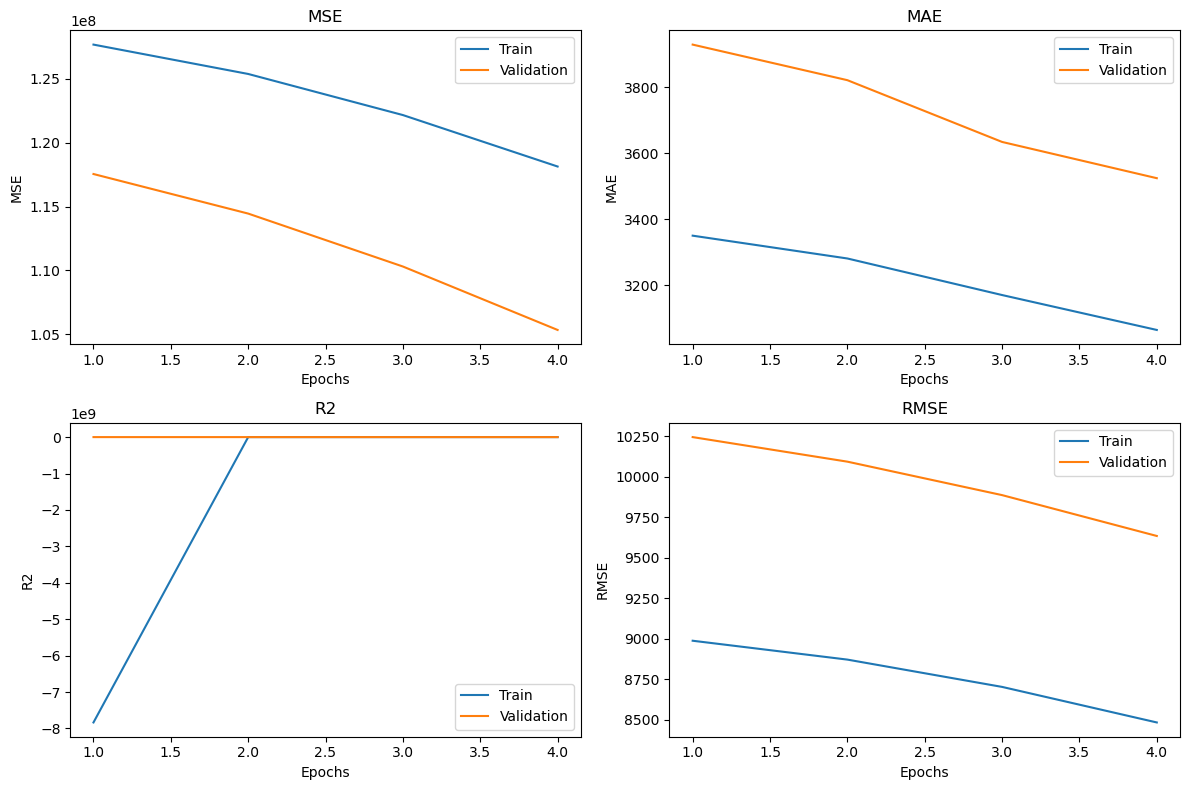

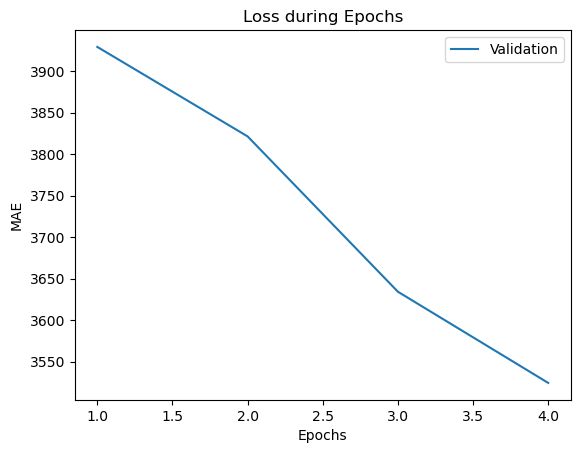

In [19]:
plot_all_metrics_train_val(metrics_val,'Validation',metrics_plot_path,gcn)
plot_single_metric(metrics_val['eval_mae_ls'],'MAE','Validation',metrics_plot_path,gcn)

### Model's Training

In [20]:
train_edges_f = np.concatenate((train_edges, val_edges), axis=0)
train_edge_weights_f = np.concatenate((train_edge_weights, val_edge_weights), axis=0)
train_node_features_f = np.concatenate((train_node_features, val_node_features), axis=0)
train_node_labels_f = np.concatenate((train_node_labels, val_node_labels), axis=0)
epochs = 4

train_loader,test_loader = graph_data_loader(batch_size, train_edges_f, train_edge_weights_f, train_node_features_f,
                                train_node_labels_f, test_edges, test_edge_weights, test_node_features, test_node_labels)

print('Graph Convolutional Network: ' + gcn)
model, metrics_test = model_training(node_features, recurent_steps, lr, epochs, train_loader, test_loader, loss_fn,
                                     gcn, filter_size, squeeze_input, recurent_type, num_nodes)


Graph Convolutional Network: TGCN2


100%|████████████████████████████████████████| 922/922 [00:03<00:00, 270.21it/s]


Epoch 1, Train || MSE: 124887806.2741323, MAE: 3479.8413774, R2: -4491470665.8568325, RMSE: 9325.4555315
Epoch 1, Evaluation || MSE: 50985116.9487180, MAE: 2665.4757612, R2: -1857.1093750, RMSE: 7062.7684295


100%|████████████████████████████████████████| 922/922 [00:03<00:00, 276.36it/s]


Epoch 2, Train || MSE: 120694656.5360629, MAE: 3340.1976681, R2: -1231.7672180, RMSE: 9119.0802603
Epoch 2, Evaluation || MSE: 47104656.8717949, MAE: 2458.1822917, R2: -209.1606070, RMSE: 6782.5841346


100%|████████████████████████████████████████| 922/922 [00:04<00:00, 219.69it/s]


Epoch 3, Train || MSE: 114288620.2715564, MAE: 3178.3733731, R2: -227.3449363, RMSE: 8782.6442516
Epoch 3, Evaluation || MSE: 41845538.3846154, MAE: 2318.4647436, R2: -66.2960111, RMSE: 6383.3525641


100%|████████████████████████████████████████| 922/922 [00:04<00:00, 198.20it/s]


Epoch 4, Train || MSE: 106145042.9936280, MAE: 2996.9921367, R2: -76.5039825, RMSE: 8326.3004338
Epoch 4, Evaluation || MSE: 35512857.4615385, MAE: 2186.8018830, R2: -22.0227802, RMSE: 5866.6278045


### Evaluation on Test set

In [22]:
mse,mae,r2,rmse,predictions,ground_truth = calculate_evalaution_metrics(model, test_loader, loss_fn, squeeze_input,num_nodes)
print("Evaluation on Test || MSE: {:.7f}, MAE: {:.7f}, R2: {:.7f}, RMSE: {:.7f}".format(mse,mae,r2,rmse))
pivot_pred,pivot_true = y_pivot(ground_truth,predictions,nodes,test_path,predictions_path,gcn)

Evaluation on Test || MSE: 35512857.4615385, MAE: 2186.8018830, R2: -22.0227802, RMSE: 5866.6278045


### Plot Metrics

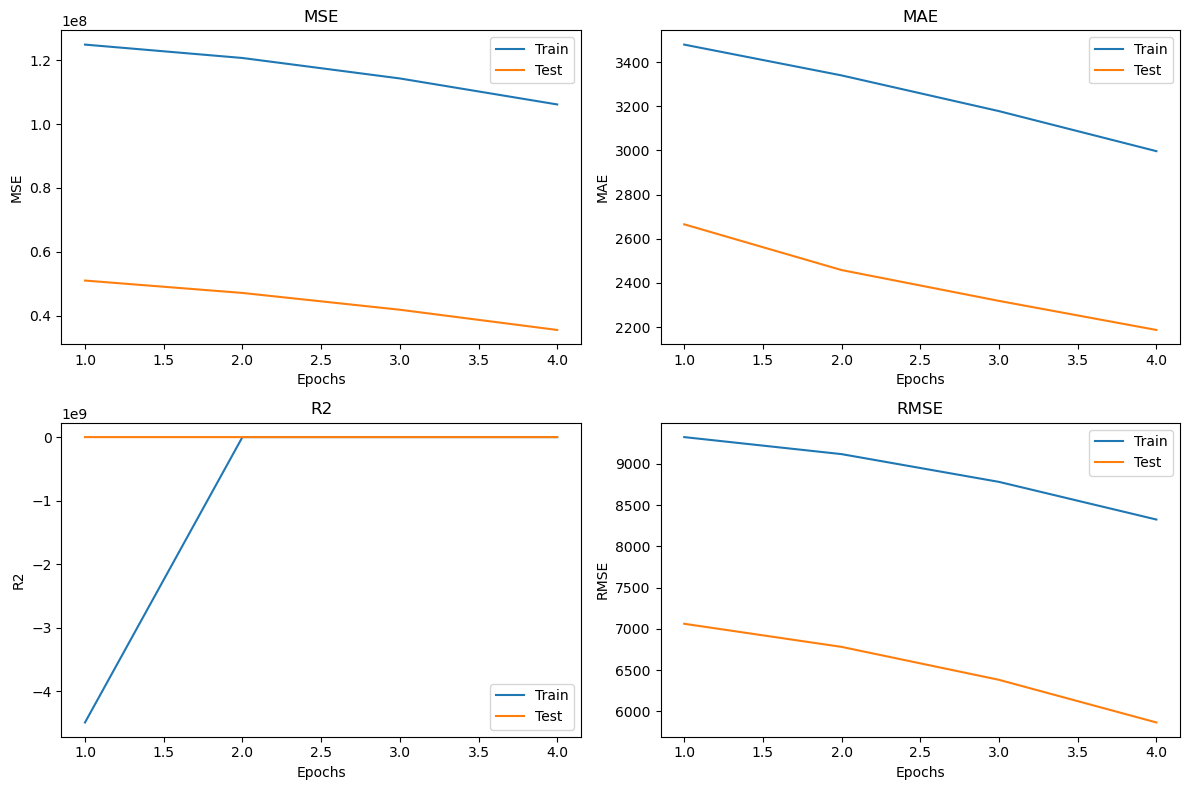

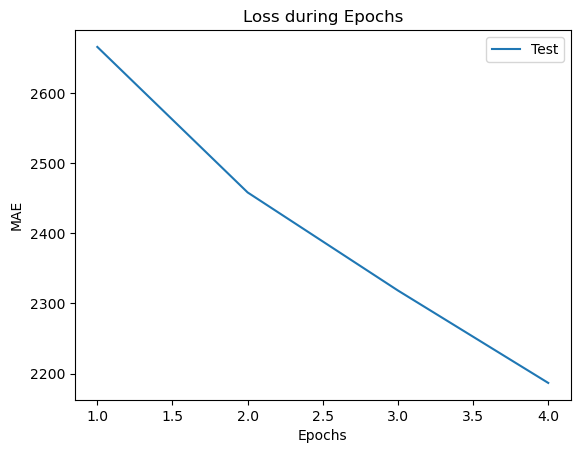

In [23]:
plot_all_metrics_train_val(metrics_test,'Test',metrics_plot_path,gcn)
plot_single_metric(metrics_test['eval_mae_ls'],'MAE','Test',metrics_plot_path,gcn)

## Experimental Evaluation "Saves & Plots"

<font size="3"> 
The objective of this section is to generate graphical representations that demonstrate the outcomes of the diverse experiments conducted for the purpose of evaluation and comparison.
<br>
<br>
At present, we have the capability to store the outcomes of our multiple experiments, and we can retrieve the results of prior experiments and depict them visually to make comparisons.
</font>

### Save experiment results

In [31]:
epxeriment_name = 'test2'
with open(results_path+gcn+'_'+epxeriment_name+'.txt', "w") as file:
    file.write(str(metrics_test['eval_mae_ls']))

### Load Results

In [33]:
with open(results_path+gcn+'_test2.txt', "r") as file:
    test1 = eval(file.readline())
with open(results_path+gcn+'_test2.txt', "r") as file:
    test2 = eval(file.readline())

### Plot Results to Compate Experiments

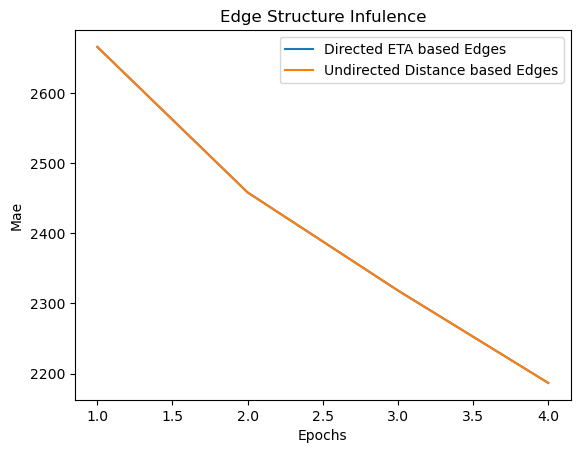

In [35]:
smooth_mae_history1 = smooth_curve(test1[0:])
smooth_mae_history2 = smooth_curve(test2[0:])
plt.plot(range(1, len(smooth_mae_history1) + 1), smooth_mae_history1,label='Directed ETA based Edges')
plt.plot(range(1, len(smooth_mae_history2) + 1), smooth_mae_history2,label='Undirected Distance based Edges')


plt.title('Edge Structure Infulence')
plt.xlabel('Epochs')
plt.ylabel('Mae')
plt.legend()
plt.savefig(results_path+"Edges.pdf")
plt.show()